In [109]:
%load_ext autoreload
%autoreload 2

import pickle
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones
# -----------------------------------------------------------------------
import sys
sys.path.append('../../')
import src.funciones as f
import src.soporte_prep as spp
import src.soporte_encoding as se
import src.soporte_logistica as sl


# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
df = pd.read_csv('../../Datos/Datos_Modelo_1/Modelo_1_CL_1.csv', index_col=0) # importo mi modelo más importante
df.head()

,Sales,Shipping Cost,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,Market,Category,Sub-Category,Discount_Category,Quantity_Group
0,2309.650,46.172483,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,184.746760,406.920476,221.649278,238.638826,417.991151
1,3709.395,45.676969,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,280.765352,376.156674,395.652475,238.638826,417.991151
2,2832.960,44.650548,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,153.708483,400.579782,601.838328,235.582284,418.867386
3,5244.840,43.421236,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,279.150012,372.352737,723.616049,235.582284,418.867386
4,4164.050,41.833998,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,183.527906,109.485297,90.500003,235.582284,173.453124


In [111]:
x= df.drop(columns='Sales')
y = df[['Sales']]

In [112]:
def metricas(y_train, y_train_pred, y_test, y_test_pred):
    metricas = {
    'train': {
        'r2_score': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
    },
    'test': {
        'r2_score': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))

    }
    }

    return pd.DataFrame(metricas).T

In [113]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.7, random_state=42)

In [114]:
modelo_lineal = LinearRegression()
modelo_lineal.fit(x_train, y_train) # aprendizaje

LinearRegression()

In [115]:
y_train_pred = modelo_lineal.predict(x_train)
y_train_pred[:3]

array([[ 50.29760783],
       [-55.67662563],
       [ 74.3570235 ]])

In [116]:
y_test_pred = modelo_lineal.predict(x_test) # predicciones, con xtest porque xtest son sus parametros. ytest son las respuestas con las que comparemos
y_test_pred[:3]

array([[122.90129487],
       [ 11.44206995],
       [472.94066249]])

In [117]:
y_test = np.array(y_test).ravel()
y_test_pred = np.array(y_test_pred).ravel()

In [118]:
metricas(y_train,y_train_pred,y_test,y_test_pred)

,r2_score,MAE,MSE,RMSE
train,0.740838,98.753396,37302.345846,193.138152
test,0.699944,100.000844,43775.999567,209.227148


Text(0, 0.5, 'Predicciones (y_test_pred)')

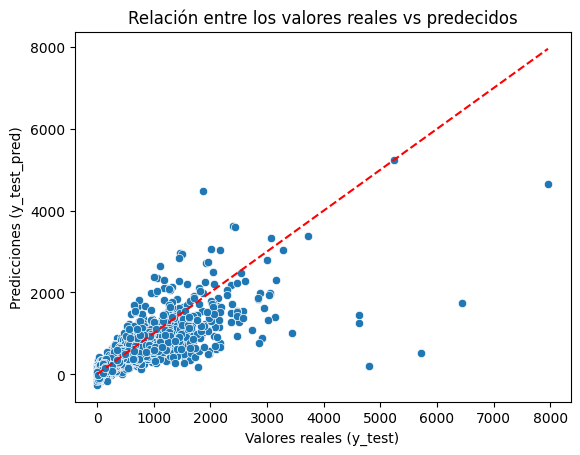

In [119]:
sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x = [min(y_test), max(y_test)], y = [min(y_test), max(y_test)], markersize = 1, color = "red", linestyle = "--")

plt.title('Relación entre los valores reales vs predecidos')
plt.xlabel('Valores reales (y_test)')
plt.ylabel('Predicciones (y_test_pred)')

## Decision Tree

In [120]:
params_arbol = {
    'max_depth': [4, 7,10,14],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 15, 20, 30],
    'max_leaf_nodes': [6, 8, 10, 20, 30]
}

In [121]:
params_arbol_2 = {
    'max_depth': [6, 7,8,9],
    'min_samples_split': [40,50,60],
    'min_samples_leaf': [18, 20,21],
    'max_leaf_nodes': [25,28,30,32,35]
}

In [122]:
params_arbol_3 = {
    'max_depth': [6, 7,8,9],
    'min_samples_split': [15, 50, 100],
    'min_samples_leaf': [20,30,40],
    'max_leaf_nodes': [32,35,40,42]
}

In [123]:
params_arbol_4 = {
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [15, 50, 100],
    'min_samples_leaf': [20,30,40],
    'max_leaf_nodes': [32,35,40,42]
}

In [124]:
params_arbol_5 = {
    'max_depth': [5],
    'min_samples_split': [30,35,40,45,50],
    'min_samples_leaf': [17,20,22],
    'max_leaf_nodes': [38,40,42]
}

In [125]:
params_arbol_6 = {
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [15, 50, 100],
    'min_samples_leaf': [20,30,40],
    'max_leaf_nodes': [32,35,40,42,50,60]
}

In [126]:
grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid=params_arbol_6,
                                 cv = 5,
                                 scoring= 'neg_mean_squared_error',
                                 n_jobs=-1)
grid_search_arbol.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_leaf_nodes': [32, 35, 40, 42, 50, 60],
                         'min_samples_leaf': [20, 30, 40],
                         'min_samples_split': [15, 50, 100]},
             scoring='neg_mean_squared_error')

In [127]:
modelo_final_arbol = grid_search_arbol.best_estimator_

In [128]:
modelo_final_arbol

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=60, min_samples_leaf=20,
                      min_samples_split=15)

In [129]:
y_test_pred_final = modelo_final_arbol.predict(x_test)
y_train_pred_final = modelo_final_arbol.predict(x_train)

In [130]:
df_metricas_arbol = metricas(y_train, y_train_pred_final, y_test, y_test_pred_final)

In [131]:
df_metricas_arbol

,r2_score,MAE,MSE,RMSE
train,0.855774,65.909411,20758.990139,144.079805
test,0.770867,70.211344,33428.867389,182.835629


In [132]:
df_resultados_arbol = pd.DataFrame(grid_search_arbol.cv_results_).sort_values(by = 'rank_test_score', ascending=True)
df_resultados_arbol.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
261,0.199906,0.081152,0.012279,0.009335,7,60,20,15,"{'max_depth': 7, 'max_leaf_nodes': 60, 'min_sa...",-30126.328894,-29785.072608,-22820.379765,-25246.537633,-19662.894595,-25528.242699,4026.839588,1
252,0.165510,0.035965,0.009641,0.004002,7,50,20,15,"{'max_depth': 7, 'max_leaf_nodes': 50, 'min_sa...",-30317.432277,-30117.410523,-23156.279915,-25474.275451,-19946.011516,-25802.281936,4010.280178,2
262,0.125617,0.022397,0.008993,0.004550,7,60,20,50,"{'max_depth': 7, 'max_leaf_nodes': 60, 'min_sa...",-30124.688303,-30291.920544,-23583.256981,-25192.241712,-20183.958432,-25875.213194,3890.378815,3
207,0.136776,0.048851,0.020732,0.024871,6,60,20,15,"{'max_depth': 6, 'max_leaf_nodes': 60, 'min_sa...",-31180.975725,-29991.386724,-22690.897872,-25672.871309,-19855.279706,-25878.282267,4278.185573,4
198,0.090335,0.009081,0.006746,0.003089,6,50,20,15,"{'max_depth': 6, 'max_leaf_nodes': 50, 'min_sa...",-31262.470068,-30107.590753,-22709.102905,-25729.674121,-19880.542382,-25937.876046,4310.392961,5
253,0.157011,0.057315,0.011226,0.006956,7,50,20,50,"{'max_depth': 7, 'max_leaf_nodes': 50, 'min_sa...",-30386.164459,-30318.317055,-23958.918576,-25270.134583,-20367.127368,-26060.132408,3854.768276,6
265,0.147883,0.029028,0.015741,0.005318,7,60,30,50,"{'max_depth': 7, 'max_leaf_nodes': 60, 'min_sa...",-31904.026386,-29992.959494,-23100.149371,-25969.977486,-20003.527672,-26194.128082,4358.452476,7
264,0.121528,0.020310,0.007628,0.003274,7,60,30,15,"{'max_depth': 7, 'max_leaf_nodes': 60, 'min_sa...",-31904.026386,-29992.959494,-23100.149371,-25969.977486,-20003.527672,-26194.128082,4358.452476,7
243,0.182239,0.052114,0.019919,0.015631,7,42,20,15,"{'max_depth': 7, 'max_leaf_nodes': 42, 'min_sa...",-30954.401450,-30377.707806,-23327.769724,-26118.178731,-20205.452613,-26196.702065,4104.839123,9
189,0.106778,0.021755,0.010553,0.005277,6,42,20,15,"{'max_depth': 6, 'max_leaf_nodes': 42, 'min_sa...",-31517.799461,-30542.070129,-23044.827978,-25951.656571,-20050.187425,-26221.308313,4358.148083,10


In [133]:
df_resultados_arbol_filtrado = df_resultados_arbol.filter(like='param').drop(columns='params')
df_resultados_arbol_filtrado['MSE'] = df_resultados_arbol['mean_test_score']
df_resultados_arbol_filtrado

,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
261,7,60,20,15,-25528.242699
252,7,50,20,15,-25802.281936
262,7,60,20,50,-25875.213194
207,6,60,20,15,-25878.282267
198,6,50,20,15,-25937.876046
...,...,...,...,...,...
22,3,40,30,50,-41670.278309
30,3,42,30,15,-41670.278309
28,3,42,20,50,-41670.278309
12,3,35,30,15,-41670.278309


In [134]:
df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby('param_max_depth')['MSE'].mean().abs()).reset_index()

In [135]:
df_rmse_prof

,param_max_depth,MSE
0,3,204.132992
1,4,181.320960
2,5,169.752783
3,6,165.368685
4,7,164.768514


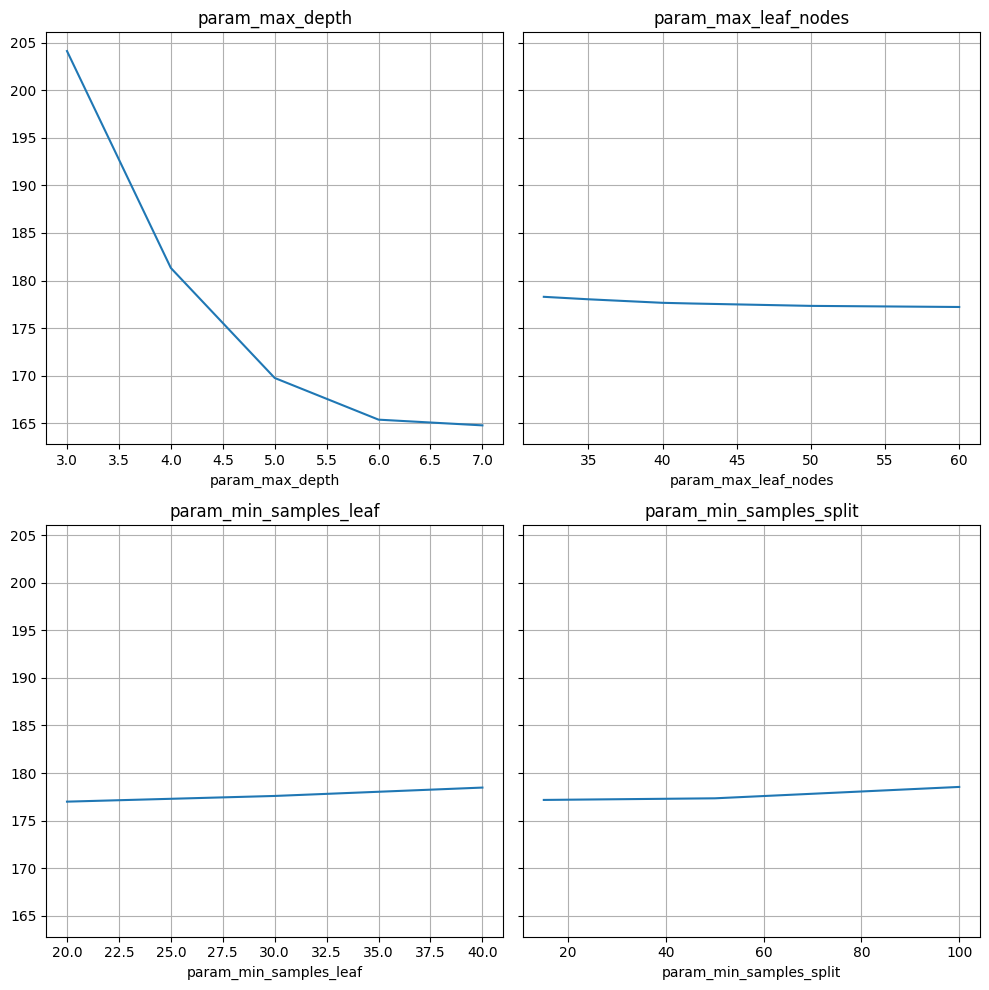

In [136]:
# df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs())
# df_rmse_prof = pd.DataFrame(df_rmse_prof).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    # Asegurarse de no exceder el número de subgráficos
    if indice >= len(axes):
        break

    df_rmse_col = np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())

    sns.lineplot(x=df_rmse_col.index, y=df_rmse_col.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)

plt.tight_layout()
plt.show() 

In [137]:
df_importancia = pd.DataFrame(modelo_final_arbol.feature_importances_,columns = ['Importancia'], index=x.columns).sort_values(by='Importancia', ascending=False)

<Axes: xlabel='Importancia', ylabel='None'>

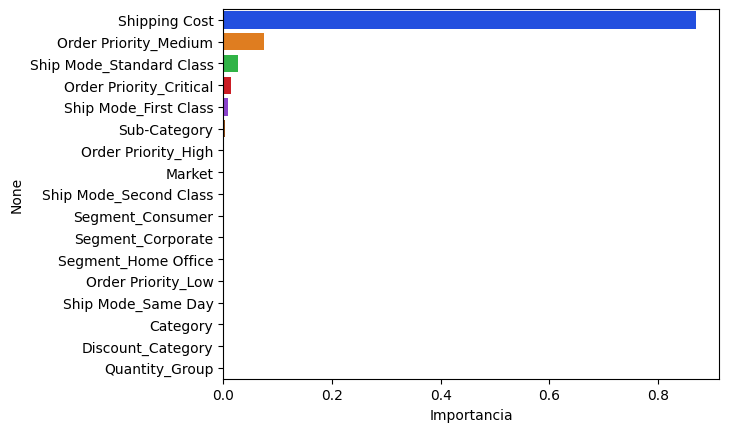

In [138]:
sns.barplot(x='Importancia', y=df_importancia.index ,data=df_importancia, palette='bright')

## Random Forest

In [139]:
params_rrf2 = {
    'n_estimators': [100, 250, 300,320,350],
    'max_features': [2,4,8,12,16],
    'max_depth': [5,6,7,8,10,12],
    'min_samples_split': [45,50,55,70],
    'min_samples_leaf': [10,12,15,20,24], 
    'max_leaf_nodes': [45,50,55,60,80,100]
}


In [140]:
params_rrf = {
    'n_estimators': [100, 250, 500,1000],
    'max_features': [2,4,8,12,16],
    'max_depth': [5,6,7],
    'min_samples_split': [45,50,55],
    'min_samples_leaf': [20], 
    'max_leaf_nodes': [45,50,55]
}

modelo_rrf = RandomForestRegressor(random_state=42, bootstrap=True,n_jobs=-1) # por este método nos pide un array

randonmized_rrf = RandomizedSearchCV(modelo_rrf, # solo hace las iteraciones que le digo
                              params_rrf2,
                              cv = 5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              random_state=50, #semilla
                              n_iter=10,
                              verbose=10)

randonmized_rrf.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_rrf = randonmized_rrf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [141]:
modelo_final_rrf

RandomForestRegressor(max_depth=7, max_features=12, max_leaf_nodes=80,
                      min_samples_leaf=20, min_samples_split=45,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [142]:
y_pred_test_rrf = modelo_final_rrf.predict(x_test)
y_pred_train_rrf = modelo_final_rrf.predict(x_train)
df_metricas_rrf = metricas(y_train, y_pred_train_rrf, y_test, y_pred_test_rrf)
df_metricas_rrf

,r2_score,MAE,MSE,RMSE
train,0.862630,60.444515,19772.195864,140.613640
test,0.785086,64.515377,31354.395642,177.071725


### Random Distinto

In [ ]:
params_rf = {
    'n_estimators': [225,250,300],
    'max_features': [10,12,14],
    'max_depth': [7,9,10,12],
    'min_samples_split': [42,45,48],
    'min_samples_leaf': [8,9,10], 
    'max_leaf_nodes': [55]
}

modelo_rf = RandomForestRegressor(random_state=42, bootstrap=True) # por este método nos pide un array

grid_search_rf = GridSearchCV(modelo_rf,
                              params_rf,
                              cv = 3,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              )

grid_search_rf.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_rf = grid_search_rf.best_estimator_

In [ ]:
modelo_final_rf

RandomForestRegressor(max_depth=7, max_features=14, max_leaf_nodes=55,
                      min_samples_leaf=8, min_samples_split=42,
                      n_estimators=300, random_state=42)

In [ ]:
y_pred_test_rf = modelo_final_rf.predict(x_test)
y_pred_train_rf = modelo_final_rf.predict(x_train)
df_metricas_rf = metricas(y_train, y_pred_train_rf, y_test, y_pred_test_rf)
df_metricas_rf

,r2_score,MAE,MSE,RMSE
train,0.866253,62.052302,19250.792040,138.747224
test,0.784487,66.400293,31441.753773,177.318227


## Gradient Booster

In [ ]:
params_gb = {
    'n_estimators': [70,90,115,200,300,320],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [5,7,9,10],
    'min_samples_split': [42,45],
    'min_samples_leaf': [8,10], 
}

modelo_gb = GradientBoostingRegressor(random_state=42) # por este método nos pide un array

grid_search_gb = GridSearchCV(modelo_gb,
                              params_gb,
                              cv = 5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)

grid_search_gb.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_gb = grid_search_gb.best_estimator_

In [ ]:
modelo_final_gb

GradientBoostingRegressor(max_depth=5, min_samples_leaf=8, min_samples_split=45,
                          n_estimators=90, random_state=42)

In [ ]:
y_pred_test_gb = modelo_final_gb.predict(x_test)
y_pred_train_gb = modelo_final_gb.predict(x_train)
df_metricas_gb = metricas(y_train, y_pred_train_gb, y_test, y_pred_test_gb)
df_metricas_gb

,r2_score,MAE,MSE,RMSE
train,0.905402,53.870742,13615.942047,116.687369
test,0.807037,61.376569,28151.980468,167.785519


## XGB

In [ ]:
params_xgb = {
    'n_estimators': [70,90,115],
    'learning_rate': [0.01, 0.05,0.1,0.2],
    'max_depth': [3,5,7,9],
    'min_child_weight': [8,10],
    'subsample': [0.8,1.0], 
    'colsample_bytree': [0.25,0.7,0.8]
}

modelo_xgb = XGBRegressor(random_state=42) # por este método nos pide un array

grid_search_xgb = GridSearchCV(modelo_xgb,
                              params_xgb,
                              cv = 3,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)

grid_search_xgb.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_xgb = grid_search_xgb.best_estimator_

In [ ]:
modelo_final_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=90, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_test_xgb = modelo_final_xgb.predict(x_test)
y_pred_train_xgb = modelo_final_xgb.predict(x_train)
df_metricas_xgb = metricas(y_train, y_pred_train_xgb, y_test, y_pred_test_xgb)
df_metricas_xgb

,r2_score,MAE,MSE,RMSE
train,0.903191,54.782926,13934.168714,118.04308
test,0.792972,62.917773,30203.892083,173.79267
